# File Setup

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import multiprocessing
from functools import partial
import time

# Load Data

In [8]:
gdf_stat_areas = gpd.read_file('statsnz-statistical-area-1-2018-generalised-SHP/statistical-area-1-2018-generalised.shp')
gdf_stat_areas = gdf_stat_areas[~gdf_stat_areas.geometry.isna()]

In [19]:
df_all_buildings = pd.read_csv('Buildings_AllNZ_AllColumns.csv')

C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (2,3,5,11,13,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
df_all_buildings = df_all_buildings.sample(1000)

In [24]:
# Create a spatial index for gdf_stat_areas
t0 = time.time()
gdf_stat_areas_sindex = gdf_stat_areas.sindex

# Create a function to find the SA1 code for a given point
def find_sa1_code(point):
    possible_matches_index = list(gdf_stat_areas_sindex.intersection((point.x, point.y)))
    possible_matches = gdf_stat_areas.iloc[possible_matches_index]
    sa1_code = possible_matches.loc[possible_matches.geometry.contains(point), "SA12018_V1"].values
    return sa1_code[0] if sa1_code else None

# Apply the function to each row in df_all_buildings and store the results in a dictionary
sa1_codes = {}
for index, row in df_all_buildings.iterrows():
    point = Point(row.x_coord, row.y_coord)
    sa1_codes[index] = find_sa1_code(point)
    if int(index)==10000:
        print(index)
        
df_all_buildings['sa1Codes'] = [sa1_codes[x] for x in df_all_buildings.index]
# df_all_buildings.to_csv('Buildings_AllNZ_AllColumns_SA1.csv',index=False)

t1 = time.time()

10000


KeyboardInterrupt: 

In [ ]:
t1-t0

In [ ]:
# Define the function to find SA1 code for a given point
def find_sa1_code(point, gdf_stat_areas):
    possible_matches_index = list(gdf_stat_areas_sindex.intersection((point.x, point.y)))
    possible_matches = gdf_stat_areas.iloc[possible_matches_index]
    sa1_code = possible_matches.loc[possible_matches.geometry.contains(point), "SA12018_V1"].values
    return sa1_code[0] if sa1_code else None

# Define a worker function to process a chunk of data
def worker(chunk, gdf_stat_areas):
    sa1_codes_chunk = {}
    for index, row in chunk.iterrows():
        point = Point(row.x_coord, row.y_coord)
        sa1_codes_chunk[index] = find_sa1_code(point, gdf_stat_areas)
    return sa1_codes_chunk


if __name__ == '__main__':
    # Split the DataFrame into chunks for parallel processing
    num_cores = multiprocessing.cpu_count()
    chunk_size = len(df_all_buildings) // num_cores
    chunks = [df_all_buildings.iloc[i:i+chunk_size] for i in range(0, len(df_all_buildings), chunk_size)]

    # Create a pool of workers
    pool = multiprocessing.Pool(processes=num_cores)

    # Apply the worker function in parallel to process each chunk of data
    results = pool.map(partial(worker, gdf_stat_areas=gdf_stat_areas), chunks)

    # Combine the results from all chunks
    sa1_codes = {}
    for result in results:
        sa1_codes.update(result)

    # Close the pool of workers
    pool.close()
    pool.join()

In [47]:
df_all_buildings

,Unnamed: 0,Outline_id,Point_id,Use_Category,UseCat_code,Construction_Type,ConType_code,Age,Storeys,Floor_Area,...,Parapet_code,Rep_Cost,Rep_Cost_multi,Units,Res_Units,NonRes_Units,Assign_type,Assign_code,x_coord,y_coord
0,0,1000102.0,Multiple,Residential Dwelling,1.0,Light Timber,5.0,1960.0,1.000000,380.0,...,0.0,886540.0,886540.0,3.0,3.0,0.0,multi-unit building,2.0,1.804526e+06,5.814188e+06
1,1,1000207.0,Multiple,Residential Dwelling,1.0,Light Timber,5.0,1990.0,1.240000,310.0,...,0.0,723230.0,723230.0,2.0,2.0,0.0,multi-unit building,2.0,1.804801e+06,5.814161e+06
2,2,1000282.0,Multiple,Mixed non-residential,24.0,Reinforced Concrete Moment Resisting Frame,2.0,1960.0,1.317919,2280.0,...,0.0,6236610.0,7421400.0,5.0,0.0,5.0,multi-unit building,2.0,1.804333e+06,5.814345e+06
3,3,1000358.0,Multiple,Residential Dwelling,1.0,Light Timber,5.0,1970.0,1.000000,237.0,...,0.0,552921.0,552921.0,2.0,2.0,0.0,multi-unit building,2.0,1.804199e+06,5.814547e+06
4,4,1000568.0,Multiple,Residential Dwelling,1.0,Light Timber,5.0,1970.0,1.000000,400.0,...,0.0,933200.0,933200.0,3.0,3.0,0.0,multi-unit building,2.0,1.805072e+06,5.814478e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3437294,132425,NaN,452151,Residential Dwelling,1.0,Light Timber,5.0,1950.0,1.000000,80.0,...,0.0,186640.0,NaN,1.0,1.0,NaN,building point without outline in parcel,5.0,1.837424e+06,5.868453e+06
3437295,132426,NaN,2714630,Lifestyle,19.0,Light Timber,5.0,2000.0,1.000000,0.0,...,0.0,0.0,NaN,1.0,NaN,1.0,building point without outline in parcel,5.0,1.896718e+06,5.768651e+06
3437296,132427,NaN,670549,Residential Dwelling,1.0,Light Timber,5.0,2020.0,1.000000,485.0,...,0.0,1131505.0,NaN,1.0,1.0,NaN,building point without outline in parcel,5.0,1.935833e+06,5.618637e+06
3437297,132428,NaN,317030,Lifestyle,19.0,Light Timber,5.0,1900.0,1.000000,0.0,...,0.0,0.0,NaN,1.0,NaN,1.0,building point without outline in parcel,5.0,1.781578e+06,5.894056e+06


In [43]:
gdf_stat_areas.loc[gdf_stat_areas.geometry.contains(Point(row.x_coord,row.y_coord)),"SA12018_V1"].values[0]

'7012471'

In [40]:
gdf_stat_areas[gdf_stat_areas.geometry.contains(Point(row.x_coord,row.y_coord))]

,SA12018_V1,LANDWATER,LANDWATER_,LAND_AREA_,AREA_SQ_KM,Shape_Leng,geometry
14470,7012245,12,Mainland,0.067782,0.067782,1219.537307,"POLYGON ((1801323.892 5815528.160, 1801395.817..."


,SA12018_V1,LANDWATER,LANDWATER_,LAND_AREA_,AREA_SQ_KM,Shape_Leng,geometry
14672,7012471,12,Mainland,0.030409,0.030409,1003.875984,"POLYGON ((1804691.401 5814423.688, 1804702.456..."


In [31]:
gdf_stat_areas

,SA12018_V1,LANDWATER,LANDWATER_,LAND_AREA_,AREA_SQ_KM,Shape_Leng,geometry
0,7000000,12,Mainland,285.489512,285.489512,192613.155735,"MULTIPOLYGON (((1601317.232 6194284.576, 16013..."
1,7000001,12,Mainland,207.202211,207.202211,135791.243048,"MULTIPOLYGON (((1582448.649 6182211.494, 15825..."
2,7000002,22,Inlet,0.000000,63.825713,165092.475327,"POLYGON ((1590890.854 6186235.530, 1590901.088..."
3,7000003,12,Mainland,69.504762,69.504762,60262.340002,"POLYGON ((1597225.802 6179455.856, 1597307.417..."
4,7000004,12,Mainland,166.507255,166.507255,74055.041890,"POLYGON ((1604492.471 6153408.641, 1604337.602..."
...,...,...,...,...,...,...,...
29869,7029858,12,Mainland,0.174990,0.174990,2079.855249,"POLYGON ((1243334.531 4828442.819, 1243463.986..."
29870,7029859,12,Mainland,3.273856,3.273856,8292.465287,"POLYGON ((1243246.568 4828109.333, 1243257.629..."
29871,7029863,12,Mainland,0.444812,0.444812,4235.220011,"POLYGON ((1243755.428 4828308.748, 1243798.340..."
29872,7029864,12,Mainland,0.444822,0.444822,5578.647776,"POLYGON ((1244395.363 4828111.817, 1244428.731..."


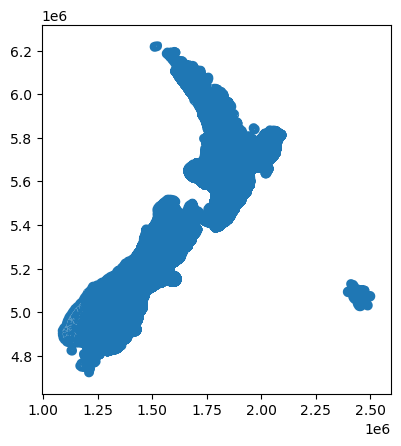

In [26]:
gdf_stat_areas.plot()

plt.scatter(df_all_buildings['x_coord'],df_all_buildings['y_coord'])

In [24]:
gdf_stat_areas.to_crs('EPSG:4326')

,SA12018_V1,LANDWATER,LANDWATER_,LAND_AREA_,AREA_SQ_KM,Shape_Leng,geometry
0,7000000,12,Mainland,285.489512,285.489512,192613.155735,"MULTIPOLYGON (((173.01433 -34.39285, 173.01461..."
1,7000001,12,Mainland,207.202211,207.202211,135791.243048,"MULTIPOLYGON (((172.80881 -34.50158, 172.81036..."
2,7000002,22,Inlet,0.000000,63.825713,165092.475327,"POLYGON ((172.90082 -34.46539, 172.90093 -34.4..."
3,7000003,12,Mainland,69.504762,69.504762,60262.340002,"POLYGON ((172.96977 -34.52657, 172.97066 -34.5..."
4,7000004,12,Mainland,166.507255,166.507255,74055.041890,"POLYGON ((173.04909 -34.76146, 173.04740 -34.7..."
...,...,...,...,...,...,...,...
29884,7999912,23,Oceanic,0.000000,0.000000,0.000000,None
29885,7999913,11,Island,0.000000,0.000000,0.000000,None
29886,7999914,23,Oceanic,0.000000,0.000000,0.000000,None
29887,7999915,11,Island,0.000000,0.000000,0.000000,None
